In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

**Extracting and Understanding the data**




In [7]:
zip_path = '/content/drive/My Drive/Colab Notebooks/kz.csv.zip'
extract_path = '/content/drive/My Drive/Colab Notebook/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

df = pd.read_csv('/content/drive/My Drive/Colab Notebook/kz.csv')
df.head(2)

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18


In [8]:
df.shape

(2633521, 8)

In [9]:
df.isnull().sum()

,0
event_time,0
order_id,0
product_id,0
category_id,431954
category_code,612202
brand,506005
price,431954
user_id,2069352


**Data Cleaning**

In [10]:
df.dropna(subset=['category_id','category_code','brand','price','user_id'],inplace=True)

In [11]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [12]:
df['timehr'] = pd.to_datetime(df['event_time']).dt.hour
def time_of_day(timehr):
  if timehr>=5 and timehr<12:
    return "Morning"
  elif timehr>=12 and timehr<16:
    return "Afternoon"
  elif timehr>=16 and timehr<23:
    return "Evening"
  else:
    return "Midnight"

df['time_bucket'] = df['timehr'].apply(time_of_day)

In [13]:
lst = df['category_code'].str.split('.')
product_type = []
for x in lst:
  if len(x)==3:
    product_type.append(x[2])
  else:
    product_type.append(x[1])

df['product_type'] = product_type

In [14]:
df['category_type'] = df['category_code'].str.split('.').str.get(0)

In [15]:
df = df[df['event_time'].dt.year != 1970]

**Data Analysis**

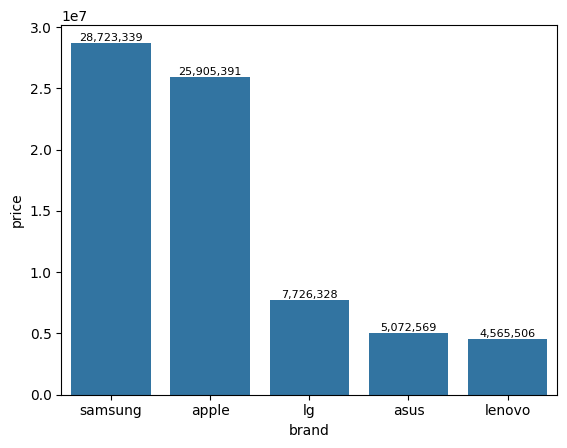

In [16]:
# Top 5 selling brands by sales

sales_by_brand = df.groupby('brand')['price'].sum().sort_values(ascending=False).head(5).reset_index()
sales_by_brand.head()
ax = sns.barplot(data = sales_by_brand,x='brand',y='price')
for container in ax.containers:
    ax.bar_label(container, labels=[f"{int(v):,}" for v in container.datavalues], fontsize=8)



/tmp/ipython-input-17-2788788590.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_month = df.groupby('Month')['price'].sum().reset_index()


<Axes: xlabel='Month', ylabel='price'>

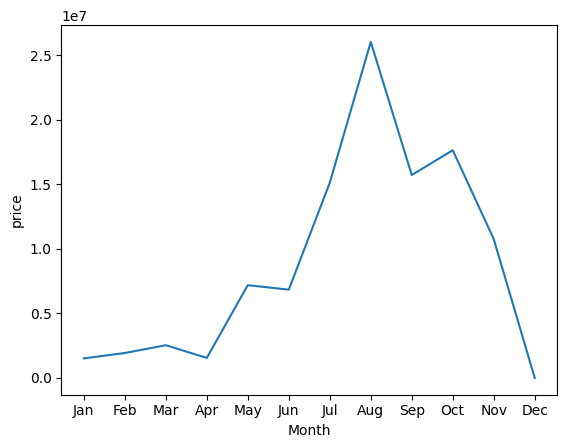

In [17]:
# Sales by month

df['Month'] = df['event_time'].dt.strftime('%b')
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month'] = pd.Categorical(df['Month'], categories = months_order, ordered=True)
sales_by_month = df.groupby('Month')['price'].sum().reset_index()
sns.lineplot(sales_by_month, x='Month',y='price')



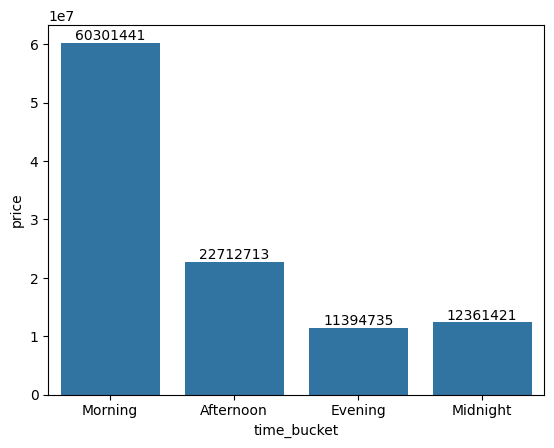

In [18]:
#Sales by time_bucket

sales_by_timebucket = df.groupby('time_bucket')['price'].sum().reset_index()
timebucket_order =['Morning','Afternoon','Evening','Midnight']
sales_by_timebucket['time_bucket'] = pd.Categorical(sales_by_timebucket['time_bucket'],categories= timebucket_order,ordered=True)
ax = sns.barplot(sales_by_timebucket,x = 'time_bucket', y = 'price')
for container in ax.containers:
  ax.bar_label(container,fmt='%.0f',fontsize=10)

In [19]:
#Sales by category and product
sales = df.groupby(['category_type','product_type'])['price'].sum().reset_index()
sales.sort_values(['category_type','price'],ascending=[True,False])
top3 =sales.groupby('category_type').head(3)
top3

,category_type,product_type,price
0,accessories,bag,62228.78
1,accessories,umbrella,885.70
2,apparel,costume,42.77
3,apparel,glove,763958.61
4,apparel,shirt,7496.11
9,appliances,air_conditioner,1826364.85
10,appliances,air_heater,106234.80
11,appliances,blender,545698.32
39,auto,alarm,32022.79
40,auto,anti_freeze,864.55


<Axes: xlabel='price', ylabel='Count'>

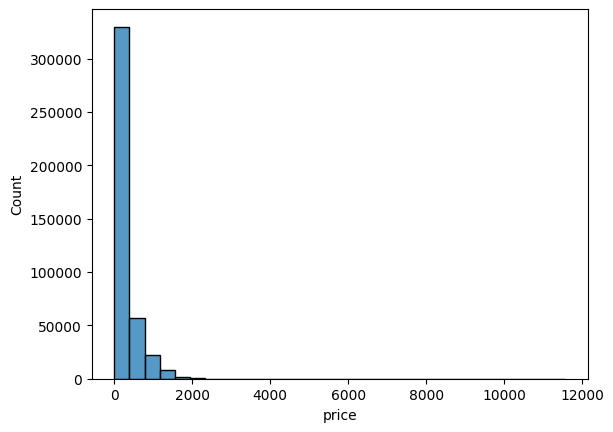

In [20]:
sns.histplot(data=df,x='price',bins=30)

([<matplotlib.patches.Wedge at 0x7f39c188a2d0>,
 [Text(-0.6816138019249925, 0.8633670279929373, 'Afternoon'),
  Text(-1.0943863174145068, -0.1109891357562282, 'Evening'),
  Text(-0.7663233526349496, -0.7891441688350305, 'Midnight'),
  Text(1.0773009936905353, -0.22231187326228305, 'Morning')],
 [Text(-0.3717893465045413, 0.47092746981432937, '21.3%'),
  Text(-0.5969379913170036, -0.06053952859430628, '10.7%'),
  Text(-0.4179945559826997, -0.43044227391001655, '11.6%'),
  Text(0.5876187238312011, -0.1212610217794271, '56.5%')])

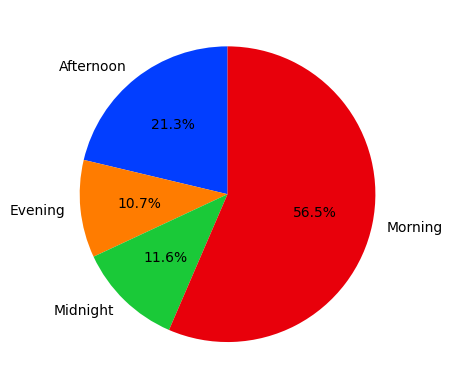

In [21]:
#Sales by time_bucket (%)

sales_by_timebucket = df.groupby('time_bucket')['price'].sum().reset_index()
timebucket_order =['Morning','Afternoon','Evening','Midnight']
sales_by_timebucket['time_bucket'] = pd.Categorical(sales_by_timebucket['time_bucket'],categories= timebucket_order,ordered=True)
plt.pie(sales_by_timebucket['price'],labels=sales_by_timebucket['time_bucket'],colors=sns.color_palette('bright'),autopct='%1.1f%%', startangle=90 )

In [22]:
from datetime import tzinfo
#RFM Analysis


df_rfm = df.loc[:,["order_id", "user_id", "event_time", "price"]]
df_rfm['event_time'] = df_rfm['event_time'].apply(lambda x: x.replace(tzinfo=None))
snapshot_date = df_rfm['event_time'].max() + pd.Timedelta(days=1)
recency = df_rfm.groupby('user_id')['event_time'].max().apply(lambda x:(snapshot_date-x).days)
frequency = df_rfm.groupby('user_id')['order_id'].count()
monetary = df_rfm.groupby('user_id')['price'].sum()

In [24]:
rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})
print(rfm)

              Recency  Frequency  Monetary
user_id                                   
1.515916e+18      136          1    416.64
1.515916e+18       25          2     56.43
1.515916e+18        5         12   5984.92
1.515916e+18       47          7   3785.72
1.515916e+18      130          2    182.83
...               ...        ...       ...
1.515916e+18        1          1    208.31
1.515916e+18        1          1   3472.20
1.515916e+18        1          2    277.74
1.515916e+18        1          1    925.67
1.515916e+18        1          1    418.96

[90781 rows x 3 columns]
